# Disaster Text Classification Using BERT 
##### By Carlos Marin

X (Formerly known as Twitter) has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

The goal is to identify and build a BERT model here predicts which Tweets are about real disasters and which one’s aren’t. To identify potential distasters before they are even reported.

In [1]:
#Importing important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import string
warnings.filterwarnings('ignore')
%matplotlib inline
from wordcloud import WordCloud
import re
import tensorflow as tf
from tensorflow.keras import models, layers
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, accuracy_score
import nltk
from sklearn.linear_model import LogisticRegression

2024-02-26 19:14:33.506662: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.



### Data Prep

The Dataset comes from Kaggle Competition, ** Natural Language Processing with Disaster Tweets** 



In [2]:
df_train = pd.read_csv('dataset/train.csv')
df_test = pd.read_csv('dataset/test.csv')

In [3]:
df_train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [4]:
df_test

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


### Understanding Data

First we look at the dataframe information, look at the Datatype (Dtype) we are going to be working with. Next we look for missing data, and fill in that missing data.

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [7]:
# looking at missing data
df_test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [8]:
#looking at missing data
df_train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [9]:
#filling missing data
df_train['keyword'] = df_train['keyword'].fillna("")
df_train["location"] = df_train["location"].fillna("")

In [10]:
#Verification of missing data
df_train.isnull().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

In [11]:
#filling missing data
df_test['keyword'] = df_test['keyword'].fillna("")
df_test["location"] = df_test["location"].fillna("")

In [12]:
#Verification of missing data
df_test.isnull().sum()

id          0
keyword     0
location    0
text        0
dtype: int64

### Univariate Distribution of Target group

Data visualization of the Target group in the dataframe.

<Axes: xlabel='target', ylabel='count'>

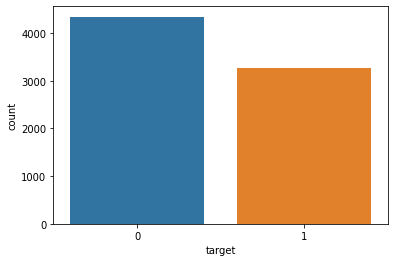

In [13]:
#looking at counts for target. Notice there is uneven distribution, will use smote to fix
sns.countplot(x = 'target', data = df_train)

### Preprocessing data - Pre-NLP techniques

First, we convert all words to lowercase.

Next we perform a a cleaning function which removes wesbites,  any punctuation, and any special cahracters.

We apply and remove **stop words** These are actually the most common words in any language (like articles, prepositions, pronouns, conjunctions, etc) and does not add much information to the text. Examples of a few stop words in English are “the”, “a”, “an”, “so”, “what”, etc..

Lastly, we apply **Stemming**. Stemming is the process of reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words. Stemming is important in natural language understanding (NLU) and natural language processing (NLP).

In [14]:
# Function, that Tokenizes words, removes links and special characters, stemming of words
stemmer = nltk.SnowballStemmer("english")
from nltk.corpus import stopwords
import string
stopword=set(stopwords.words('english'))

def clean(text):
    
    #applying lowercase 
    text = str(text).lower()
    
    #Text Cleaning function
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    #removing stopwords
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    
    #stemming of words
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    
    return text

In [15]:
#Applying function to text data
df_train['text']= df_train['text'].apply(clean)

df_test['text']= df_test['text'].apply(clean)

In [16]:
# remove short words, less than 3 letters long
df_train['text'] = df_train['text'].apply(lambda x: " ".join([w for w in x.split() if len(w)>3]))
df_test['text'] = df_test['text'].apply(lambda x: " ".join([w for w in x.split() if len(w)>3]))

### Generating WordClouds - Preparation



Word Cloud is a data visualization technique used for representing text data in which the size of each word indicates its frequency or importance. This technique is very common when analzing data from social media.

For Visualization, we seperate the targets groups. 



From those different Target Dataframes, **text** is selected. Before we can visualize the words. we need to convert the list into one long string using Python's map function.



In [17]:
#Seperating by different targets
df1 = df_train.loc[df_train.target == 1]
df2 = df_train.loc[df_train.target == 0]

In [18]:
#Using Only the text column
df1  = df1['text']
df2 = df2['text']

In [19]:
df1 = ''.join(map(str, df1))
df2 = ''.join(map(str, df2))

### Wordcloud for Positve or '1' Target Group

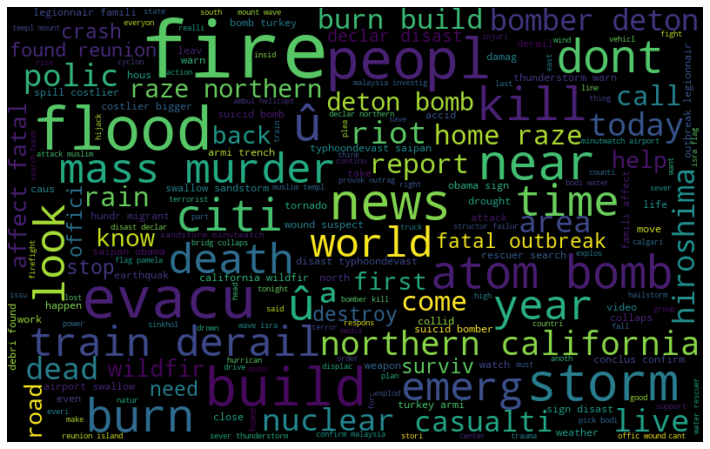

In [20]:
#Wordcloud for when target is 1
wordcloud = WordCloud(width=800, height=500, max_font_size=90 , random_state=42).generate(df1)


                      
# plotting the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Wordcloud for Negative or '0' Target Group

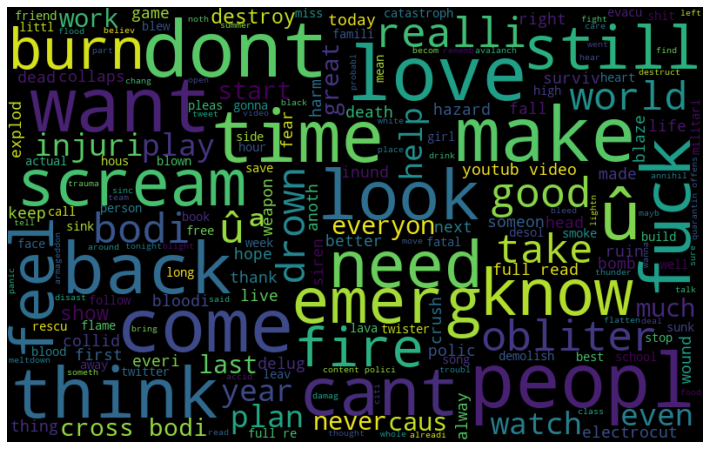

In [21]:
#Wordcloud for when target is 0
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=90).generate(df2)

# plotting the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Splitting The data for pre-BERT.

The train-test split procedure is used to estimate the performance of machine learning algorithms when they are used to make predictions on data not used to train the model.

Using Train Test Split, we will convert the dataset into training and test set.

**Train Dataset**: Used to fit the machine learning model.

**Test Dataset**: Used to evaluate the fit machine learning model.

Next they will be split into two group. The first group will be text, and the next group is the target. This is done for both train and test sets

In [22]:
train_data, test_data = train_test_split(df_train, test_size = 0.30, 
                                         random_state = 777 )

text = train_data['text'].values
target = train_data['target'].values

test_text = test_data['text'].values
test_target = test_data['target'].values

### Bidirectional Representation for Transformers (BERT)

**BERT** stands for **Bidirectional Representation for Transformers** and was proposed by researchers at Google AI language in 2018. Although the main aim of that was to improve the understanding of the meaning of queries related to Google Search, BERT becomes one of the most important and complete architectures for various natural language tasks having generated state-of-the-art results on Sentence pair classification tasks, question-answer tasks, etc.

BERT is a powerful technique for natural language processing that can improve how well computers comprehend human language. The foundation of BERT is the idea of exploiting bidirectional context to acquire complex and insightful word and phrase representations. By simultaneously examining both sides of a word’s context, BERT can capture a word’s whole meaning in its context, in contrast to earlier models that only considered the left or right context of a word. This enables BERT to deal with ambiguous and complex linguistic phenomena including polysemy, co-reference, and long-distance relationships.

In [23]:
#Importing BERT model and BERT Tokenizer
from transformers import BertTokenizer, TFBertForSequenceClassification

### BERT Tokenization and Encoding

BERT tokenization is used to convert the raw text into numerical inputs that can be fed into the BERT model. It tokenized the text and performs some preprocessing to prepare the text for the model’s input format. Let’s understand some of the key features of the BERT tokenization model.

BERT tokenizer splits the words into subwords or workpieces. For example, the word “workforhire” can be split into “work” “##for”, and”##hire”. The “##” prefix indicates that the subword is a continuation of the previous one. It reduces the vocabulary size and helps the model to deal with rare or unknown words.

BERT tokenizer adds special tokens like **[CLS], [SEP], and [MASK]** to the sequence. These tokens have special meanings like :

**[CLS]** is used for classifications and to represent the entire input in the case of text classification,

**[SEP]** is used as a separator i.e. to mark the boundaries between different sentences or segments,

**[MASK]** is used for masking i.e. to hide some tokens from the model during pre-training.



BERT tokenizer gives their components as outputs:

**input_ids**: The numerical identifiers of the vocabulary tokens

**token_type_ids**: It identifies which segment or sentence each token belongs to.

**attention_mask**: It flags that inform the model which tokens to pay attention to and which to disregard.

In [24]:
#Loading The Pre-trained BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


### Applying BERT Tokenizer to the Training and Test Set

In [25]:
max_len= 128
# Tokenize and encode the sentences
train_encoded = tokenizer.batch_encode_plus(text.tolist(),
                                            padding=True, 
                                            truncation=True,
                                            max_length = max_len,
                                            return_tensors='tf')

test_encoded = tokenizer.batch_encode_plus(test_text.tolist(), 
                                           padding=True, 
                                           truncation=True,
                                           max_length = max_len,
                                           return_tensors='tf')

### Loading the BERT Classification Model

In [26]:
# Intialize the model
modelB = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                         num_labels=2)
modelB.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Compiling & Fitting the Model

In [27]:
#Compiling the model
modelB.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
#Training the model
history = modelB.fit([train_encoded['input_ids'], 
                      train_encoded['token_type_ids'], 
                      train_encoded['attention_mask']],
                     target,
                     validation_data=([test_encoded['input_ids'],
                                       test_encoded['token_type_ids'], 
                                       test_encoded['attention_mask']],
                                      test_target),
                     epochs=3)


Epoch 1/3
167/167 [==============================] - 1663s 10s/step - loss: 0.5284 - accuracy: 0.7500 - val_loss: 0.4815 - val_accuracy: 0.7877
Epoch 2/3
167/167 [==============================] - 1634s 10s/step - loss: 0.4146 - accuracy: 0.8268 - val_loss: 0.5004 - val_accuracy: 0.7732
Epoch 3/3
167/167 [==============================] - 1669s 10s/step - loss: 0.3442 - accuracy: 0.8713 - val_loss: 0.5158 - val_accuracy: 0.7890


### Visualization of Model Performance

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 0, 'Epochs')

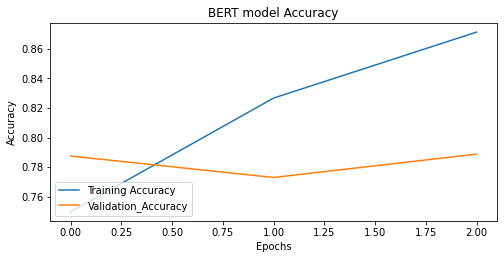

In [30]:
#Visualization of accuracy
plt.figure(figsize = (8,8))
plt.subplot(2,1,1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation_Accuracy')
plt.legend(loc = "lower left")
plt.title('BERT model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

Text(0.5, 0, 'Epochs')

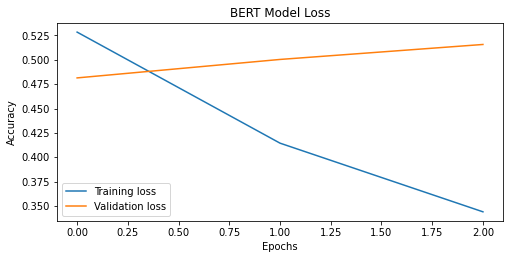

In [31]:
#Visualization of Loss
plt.figure(figsize = (8,8))
plt.subplot(2,1,1)
plt.plot(loss, label = 'Training loss')
plt.plot(val_loss, label = 'Validation loss')
plt.legend(loc = "lower left")
plt.title('BERT Model Loss')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

### Evaluating model performance

In [32]:
#Evaluate the model on the test data
test_loss, test_accuracy = modelB.evaluate(
[test_encoded['input_ids'], test_encoded['token_type_ids'], 
 test_encoded['attention_mask']],
test_target)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')


72/72 [==============================] - 188s 3s/step - loss: 0.5158 - accuracy: 0.7890
Test loss: 0.5157553553581238, Test accuracy: 0.788966715335846


In [33]:
pred = modelB.predict(
[test_encoded['input_ids'], test_encoded['token_type_ids'], 
     test_encoded['attention_mask']])

# pred is of type TFSequenceClassifierOutput
logits = pred.logits

# Use argmax along the appropriate axis to get the predicted labels
pred_labels = tf.argmax(logits, axis=1)

# Convert the predicted labels to a NumPy array
pred_labels = pred_labels.numpy()

label = {
1: 'Positive',
0: 'Negative'
}

# Map the predicted labels to their corresponding strings using the label dictionary
pred_labels = [label[i] for i in pred_labels]
Actual = [label[i] for i in test_target]

print('Predicted Label :', pred_labels[:10])
print('Actual Label :', Actual[:10])


72/72 [==============================] - 186s 3s/step
Predicted Label : ['Positive', 'Positive', 'Positive', 'Negative', 'Positive', 'Negative', 'Negative', 'Negative', 'Negative', 'Positive']
Actual Label : ['Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Negative', 'Negative', 'Negative', 'Negative', 'Positive']


In [34]:
print(classification_report(Actual, pred_labels))


              precision    recall  f1-score   support

    Negative       0.81      0.82      0.81      1278
    Positive       0.76      0.75      0.76      1006

    accuracy                           0.79      2284
   macro avg       0.79      0.79      0.79      2284
weighted avg       0.79      0.79      0.79      2284



#### Classification report

Precision: Percentage of correct positive predictions relative to total positive predictions.

Recall: Percentage of correct positive predictions relative to total actual positives.

F1 Score: A weighted harmonic mean of precision and recall. The closer to 1, the better the model.

F1 Score: 2 * (Precision * Recall) / (Precision + Recall)

Accuracy: One of the more obvious metrics, it is the measure of all the correctly identified cases. It is most used when all the classes are equally important.

#### BERT MODEL results Conclusion (to be changed based on final results)

Interpretation of classification report

**Precision**:

Out of both of the Targets that the model predicted, for **negative** Target classification it was correct 81% of the time.


Out of both of the Targets that the model predicted, for **Positive** Target classification it was correct 76% of the time.

**Recall:**

The model only predicted the negative text classification correctly for 82% of those tweets.

The model only predicted the positive text classification correctly for 75% of those tweets.

**f1 score:**

The **Negative** text classification f1 score is 0.81, a good job.

The **Positive** text clasification f1 score is 0.76, a good job.

**Accuracy**

The Accuracy for the BERT Model is 79%

### Text Classificaton using traditional techniques (CountVectorizer and TFIDF Vectorizer)

In [36]:
#importing packages and wordVectorizers
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

#Initializing SMOTE
smote = SMOTE(random_state = 777)

df = df_train
x = df['text']
y = df['target'] 

### Model Training - COUNT VECTORIZER

**CountVectorizer** is a tool provided by Python's scikit-learn library.It is used to transform a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text.

First we identify our target variable 'Y', which will be Target, the 'X' is the response variable which will be the 'Text'.

The Countvectorizer is called and assigned a variable, it is called 'cv' here.

The response variable is fitted on the CountVectorizer, and assign it a new variable. With this new variable, we call the train test split.

#### Train Test Split

Train Test Split here splits the data into test sets and train sets. We set the test size to 30% of the data, to maintain consistency as our BERT model.

In [37]:
#Instantiating CountVectorizer
cv = CountVectorizer(max_features = 1000, stop_words = 'english')
#Fitting data
cvx = cv.fit_transform(x)

#Instantiating TFIDF Vectorizer 
tf = TfidfVectorizer (ngram_range = (1,2), max_features = 50000)
#Fitting the data
tfx = tf.fit_transform(x)

In [38]:
#train test split with count vectorizer
x_train, x_test, y_train, y_test = train_test_split(cvx, y, 
                                                    random_state = 777, 
                                                    test_size = 0.3)

### SMOTE: Synthetic Minority Over-sampling Technique
 Because there was a slight class imbalance. This will be fixed using SMOTE

SMOTE stands for Synthetic Minority Oversampling. Here, rather then simply oversampling the minority class with replacement (which simply adds duplicate cases to the dataset), the algorithm generates new sample data by creating 'synthetic' examples that are combinations of the closest minority class cases.

In [39]:
#using SMOTE to fix oversampling
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 777)
x_train, y_train = smote.fit_resample(x_train, y_train)

# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(y_train.value_counts())

-----------------------------------------
Synthetic sample class distribution: 

target
1    3064
0    3064
Name: count, dtype: int64


### Logistic Regression & GridSearch CV

**Logistic regression** is used to describe data and to explain the relationship between one dependent binary variable and one or more independent variables. I

First starting out, we will instantiate the model.

Next we set the paramerters for grid searchCV. Here we are using Solver, which is an algorithm used in the optimization problem. For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones.

Then we use **GridsearchCV**. GridSearchCV is a technique to search through the best parameter values from the given set of the grid of parameters.

we fit the data, and then use .best_params_ which tells use the best parameters for our model. Lastly given the parameters to use, we Instantiate them model with set parameters.

In [40]:
#instantiating Logistic Regression
model = LogisticRegression()

#Parameters for GridSearchCV
log_grid = {'solver': ['liblinear', 'sag', 'saga'], 
            'penalty': ['l1', 'l2', 'elasticnet', 'None']}

log = GridSearchCV(model, log_grid, scoring = 'accuracy', cv = 3 )

#fitting training unto model
log.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'penalty': ['l1', 'l2', 'elasticnet', 'None'],
                         'solver': ['liblinear', 'sag', 'saga']},
             scoring='accuracy')

In [41]:
log.best_params_

{'penalty': 'l2', 'solver': 'saga'}

In [42]:
log = LogisticRegression(solver = 'saga', penalty = 'l2', random_state = 777)

#fitting training unto model
log.fit(x_train, y_train)

LogisticRegression(random_state=777, solver='saga')

### Confusion matrix for binary classification

In the field of machine learning and specifically the problem of statistical classification, a confusion matrix, also known as an error matrix, is a specific table layout that allows visualization of the performance of an algorithm.


The information included in the confusion matrix are

**True Positive Rate** The true positive rate (TPR, also called sensitivity). TPR is the probability that an actual positive will test positive.

**False Positive Rate** The False Positive Rate (FPR, or “Fall-Out”), is the proportion of negative cases incorrectly identified as positive cases in the data (i.e. the probability that false alerts will be raised).

**true negative rate(TN)** - A test result that correctly indicates the absence of a condition or characteristic

**false negative rate (FN)** - A test result which wrongly indicates that a particular condition or attribute is absent

First we create predictions

Next, using the confusion plot we Y_test set with predictions to get True Positive Rate, False Positive Rate, True Negative Rate, and False Negative Rate.

In [43]:
#Creating Confusion Matrix for Model Evaluation
from sklearn.metrics import confusion_matrix

#Creating prediction dataset
cv_preds = log.predict(x_test)

cm = confusion_matrix(y_test, cv_preds)
TN, FP, FN, TP = confusion_matrix(y_test, cv_preds).ravel()

print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

accuracy =  (TP+TN) /(TP+FP+TN+FN)

print('Accuracy of the binary classification = {:0.3f}'.format(accuracy))

True Positive(TP)  =  722
False Positive(FP) =  294
True Negative(TN)  =  984
False Negative(FN) =  284
Accuracy of the binary classification = 0.747


### Classification Report of CountVectorizer Model

In [44]:
#Creating Classification Report
print(classification_report(y_test, cv_preds, 
                            target_names = ['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.78      0.77      0.77      1278
    Positive       0.71      0.72      0.71      1006

    accuracy                           0.75      2284
   macro avg       0.74      0.74      0.74      2284
weighted avg       0.75      0.75      0.75      2284



### CountVectorizer Model results Conclusion

Interpretation of classification report

**Precision**:

Out of both of the Targets that the model predicted, for **negative** Target classification it was correct 78% of the time.


Out of both of the Targets that the model predicted, for **Positive** Target classification it was correct 71% of the time.

**Recall:**

The model only predicted the negative text classification correctly for 77% of those tweets.

The model only predicted the positive text classification correctly for 72% of those tweets.

**f1 score:**

The **Negative** text classification f1 score is 0.77, a good job.

The **Positive** text clasification f1 score is 0.71, a good job.

**Accuracy**

The Accuracy for the CountVectorizer Model is 75%

### Analysis using TFIDF Vectorizer

In [45]:
#train test split with tfidf vectorizer
x_train, x_test, y_train, y_test = train_test_split(tfx, y, random_state = 777, test_size = 0.2)

In [46]:
#using SMOTE to fix oversampling
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 777)
x_train, y_train = smote.fit_resample(x_train, y_train)

# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(y_train.value_counts())

-----------------------------------------
Synthetic sample class distribution: 

target
0    3490
1    3490
Name: count, dtype: int64


In [47]:
#instantiating Logistic Regression
model = LogisticRegression()


#Parameters for GridSearchCV
log_grid2 = {'solver': ['liblinear', 'sag', 'saga'], 
            'penalty': ['l1', 'l2', 'elasticnet', 'None']}

log = GridSearchCV(model, log_grid2, scoring = 'accuracy', cv = 3 )

#fitting training unto model
log.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'penalty': ['l1', 'l2', 'elasticnet', 'None'],
                         'solver': ['liblinear', 'sag', 'saga']},
             scoring='accuracy')

In [48]:
log.best_params_

{'penalty': 'l2', 'solver': 'sag'}

In [49]:
model = LogisticRegression(solver = 'sag', penalty = 'l2', random_state = 777)
#fitting training unto model
model.fit(x_train, y_train)

LogisticRegression(random_state=777, solver='sag')

In [50]:
#Creating Prediction dataset
tf_preds = model.predict(x_test)

#Running Classification Report
print(classification_report(y_test, tf_preds,
                           target_names = ['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.77      0.88      0.82       852
    Positive       0.81      0.67      0.73       671

    accuracy                           0.78      1523
   macro avg       0.79      0.77      0.78      1523
weighted avg       0.79      0.78      0.78      1523



In [51]:
#Confusion matrix of TFIDF Vectorizer

cm = confusion_matrix(y_test, tf_preds)
TN, FP, FN, TP = confusion_matrix(y_test, tf_preds).ravel()

print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

accuracy =  (TP+TN) /(TP+FP+TN+FN)

print('Accuracy of the binary classification = {:0.3f}'.format(accuracy))

True Positive(TP)  =  448
False Positive(FP) =  106
True Negative(TN)  =  746
False Negative(FN) =  223
Accuracy of the binary classification = 0.784


### TFIDF Model results Conclusion

Interpretation of classification report

**Precision**:

Out of both of the Targets that the model predicted, for **negative** Target classification it was correct 77% of the time.


Out of both of the Targets that the model predicted, for **Positive** Target classification it was correct 81% of the time.

**Recall:**

The model only predicted the negative text classification correctly for 88% of those tweets.

The model only predicted the positive text classification correctly for 67% of those tweets.

**f1 score:**

The **Negative** text classification f1 score is 0.82, a good job.

The **Positive** text clasification f1 score is 0.73, a good job.

**Accuracy**

The Accuracy for the TFIDF Model is 78%

### Summary of Results / Conclusion

THE BERT MODEL(TFBertForSequenceClassification) does a great job, the TFIDF model comes as a close second and the CountVectorizer Model is the third best

Next steps...

Collect data within 6 months to evaluate model performance

Based on the texts, make improvements to to model to more accurately improve model performance

### APPENDIX I : RECURRENT NEURAL NETWORKS (RNN)

**Recurrent Neural Networks** or **RNN** as they are called in short, are a very important variant of neural networks heavily used in Natural Language Processing.

RNN is widely used neural network architecture for NLP. It has proven to be comparatively accurate and efficient for building language models and in tasks of speech recognition.

First we again perform train test split, to split the data into training data and testing data.


In [52]:
df  = df_train
#performing train_test_split
train_data, test_data = train_test_split(df, test_size=0.20, random_state=7)

### Tokenization using Keras
Tokenization is used in natural language processing to split paragraphs and sentences into smaller units that can be more easily assigned meaning.

A few keywords here:

**tokenizer** create tokens for every word in the data corpus and map them to a index using dictionary.

**word_index** assigns a unique index to each word present in the text. This unique integer helps the model during training purposes.

**vocab_size** represents the total number of word in the data corpus

In This portion we call the tokenizer, and fit it on the train set of the Final_Post. Next I assign the word index. Then based on the word index, we use that to get the length and this will be the vocabulary size

In [53]:
#Importing Tokenizer from Keras Library
from keras.preprocessing.text import Tokenizer

#Assigning the Tokenizer a variable
tokenizer = Tokenizer()

#Fitting the Tokenizer to the training data portion of the Final_Post
tokenizer.fit_on_texts(train_data.text)


#Assigning the word_index
word_index = tokenizer.word_index

#Gathering vocab size based on word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 10775


### Setting up X_train and X_test, by converting to integers
**pad_sequences** is used to ensure that all sequences in a list have the same length.

**texts_to_sequences** method helps in converting tokens of text corpus into a sequence of integers.

**Maxlen** is maxiumum length of sequences.

First we import our packages. Next set up our X_train and X_test variables. This is done by. calling pad_sequences then inside a parenthesis, we call tokenizer with texts to sequences, then inside another parrenthesis the train data/test data final_post column.

In [54]:
from keras.preprocessing import sequence
from keras.utils import pad_sequences

MAX_WORDS = 30

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text), maxlen = MAX_WORDS)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text), maxlen = MAX_WORDS)

### Label Encoding Y_train and Y_test
**Label Encoding**  refers to converting the labels into a numeric form so as to convert them into the machine-readable form.

Here we are converting the different targets into a an encoded form (0,1).

In [55]:
#Importing LabelEncoder from sklearn
from sklearn.preprocessing import LabelEncoder

#Assigning LabelEncoder a variable
encoder = LabelEncoder()

#Fitting the training data into the Encoder
encoder.fit(train_data.target)

#Transforming train data and test data using encoder
y_train = encoder.transform(train_data.target)
y_test = encoder.transform(test_data.target)


#Reshaping data
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

#Printing Shape
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


y_train shape: (6090, 1)
y_test shape: (1523, 1)


In [56]:
#using SMOTE to fix oversampling
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 777)
x_train, y_train = smote.fit_resample(x_train, y_train)

### Building our Keras Model
We are clear now to start building our Keras Model.

I will be using the **Sequential** model, which is very straightforward (a simple list of layers), but is limited to single-input, single-output stacks of layers (as the name gives away).

For model architecture, I use:

1) Embedding Layer - Generates Embedding Vector for each input sequence.

2) LSTM - Long Short Term Memory, its a variant of RNN which has memory state cell to learn the context of words which are at further along the text to carry contextual meaning rather than just neighbouring words as in case of RNN.

3) Dense - Fully Connected Layers for classification

4) Dropout - Prevents Overfitting

In [57]:
#Importing important packages
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense,Dropout
from keras.callbacks import EarlyStopping

#Building our model
model = Sequential()
model.add(Embedding(50000, 128))
model.add(Dense(32, input_shape=(16,), activation=None))
model.add(Dropout(0.7))
model.add(Dense(16, input_shape=(8,), activation=None))
model.add(Dropout(0.7))
model.add(LSTM(250, dropout=0.7, recurrent_dropout = 0.5))
model.add(Dropout(0.7))
model.add(Dense(4, activation='softmax'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         6400000   
                                                                 
 dense (Dense)               (None, None, 32)          4128      
                                                                 
 dropout_38 (Dropout)        (None, None, 32)          0         
                                                                 
 dense_1 (Dense)             (None, None, 16)          528       
                                                                 
 dropout_39 (Dropout)        (None, None, 16)          0         
                                                                 
 lstm (LSTM)                 (None, 250)               267000    
                                                                 
 dropout_40 (Dropout)        (None, 250)               0

### Compiling and running our model

By compiling our model, we are configuring our model for training

The loss is sparse categorical crossentropy - Computes the crossentropy loss between the labels and predictions

Optimizer is Adam - Optimizer which implements the Adam Algorithm

metrics: List of metrics to be evaluated by the model during training and testing. We have set it to accuracy.

### Fitting & Running the model

As we do with machine learning:

First we fit the the trainig data

for Validation_data we set our test data

validation_split: Between 0 and 1. Fraction of the training data to be used as validation data. The model will set apart this fraction

In [58]:
#compiling our model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [59]:
#fitting the model
history = model.fit(x_train, y_train, epochs = 10, validation_data=(x_test, y_test), validation_split = 0.4)

Epoch 1/10
218/218 [==============================] - 64s 282ms/step - loss: 0.7377 - accuracy: 0.5372 - val_loss: 0.6136 - val_accuracy: 0.6953
Epoch 2/10
218/218 [==============================] - 68s 310ms/step - loss: 0.5244 - accuracy: 0.7435 - val_loss: 0.4726 - val_accuracy: 0.7892
Epoch 3/10
218/218 [==============================] - 68s 313ms/step - loss: 0.3891 - accuracy: 0.8291 - val_loss: 0.5161 - val_accuracy: 0.7689
Epoch 4/10
218/218 [==============================] - 67s 305ms/step - loss: 0.3211 - accuracy: 0.8733 - val_loss: 0.5882 - val_accuracy: 0.7577
Epoch 5/10
218/218 [==============================] - 65s 300ms/step - loss: 0.2871 - accuracy: 0.8845 - val_loss: 0.6641 - val_accuracy: 0.7498
Epoch 6/10
218/218 [==============================] - 63s 289ms/step - loss: 0.2702 - accuracy: 0.8927 - val_loss: 0.7027 - val_accuracy: 0.7544
Epoch 7/10
218/218 [==============================] - 62s 284ms/step - loss: 0.2438 - accuracy: 0.9081 - val_loss: 0.6684 - val_ac

### Visualization of Accuracy and Loss Per Epoch

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 0, 'Epochs')

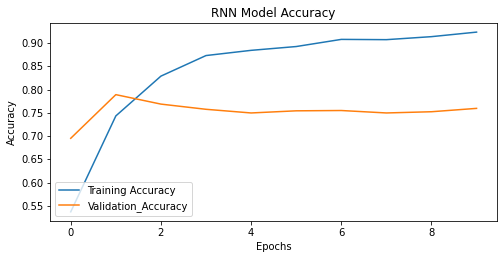

In [61]:
#Visualization of accuracy
plt.figure(figsize = (8,8))
plt.subplot(2,1,1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation_Accuracy')
plt.legend(loc = "lower left")
plt.title('RNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

Text(0.5, 0, 'Epochs')

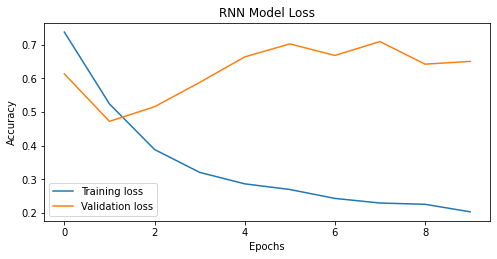

In [62]:
#Visualization of Loss
plt.figure(figsize = (8,8))
plt.subplot(2,1,1)
plt.plot(loss, label = 'Training loss')
plt.plot(val_loss, label = 'Validation loss')
plt.title('RNN Model Loss')
plt.legend(loc = "lower left")
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

### Creating Predictions dataset

In [63]:
raw_predictions = model.predict(x_test)

48/48 [==============================] - 2s 41ms/step


In [64]:
preds = np.argmax(raw_predictions, axis =-1)

### Confusion Matrix and Classification Report

In [65]:
#Running Classification report
print(classification_report(y_test, preds,
                           target_names = ['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.78      0.80      0.79       861
    Positive       0.73      0.70      0.72       662

    accuracy                           0.76      1523
   macro avg       0.76      0.75      0.75      1523
weighted avg       0.76      0.76      0.76      1523



In [66]:
#creating copnfusion matrix
cm = confusion_matrix(y_test, preds)
TN, FP, FN, TP = confusion_matrix(y_test, preds).ravel()

print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

accuracy =  (TP+TN) /(TP+FP+TN+FN)

print('Accuracy of the binary classification = {:0.3f}'.format(accuracy))

True Positive(TP)  =  466
False Positive(FP) =  170
True Negative(TN)  =  691
False Negative(FN) =  196
Accuracy of the binary classification = 0.760


### RNN Model results Conclusion

Interpretation of classification report

**Precision**:

Out of both of the Targets that the model predicted, for **negative** Target classification it was correct 78% of the time.


Out of both of the Targets that the model predicted, for **Positive** Target classification it was correct 73% of the time.

**Recall:**

The model only predicted the negative text classification correctly for 80% of those tweets.

The model only predicted the positive text classification correctly for 70% of those tweets.

**f1 score:**

The **Negative** text classification f1 score is 0.79, a good job.

The **Positive** text clasification f1 score is 0.72, a good job.

**Accuracy**

The Accuracy for the RNN Model is 76%

**Conclusion**
Model Performance improves with each Epoch, but also overfitting a side of effect